negrito# Estudo de Caso: deep learning para imagens odontológicas

1. Importando as bibliotecas:

In [105]:
import numpy as np
import pandas as pd

In [106]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [107]:
from google.colab import drive
drive.mount('/content/drive')

In [108]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

In [109]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

2. Definindo as propriedades das imagens:

In [110]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

3. Preparando o conjunto de dados para o modelo de treinamento:

In [111]:
filenames=os.listdir("Dataset/Treino")

In [112]:
categories=[]

In [113]:
for f_name in filenames:
     category=f_name.split('.')[0]
     if category=='caries':
        categories.append(1)
     else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

df.head()


,filename,category
0,normal.84.png,0
1,caries.2.png,1
2,normal.44.png,0
3,normal.155.png,0
4,normal.80.png,0


<AxesSubplot:>

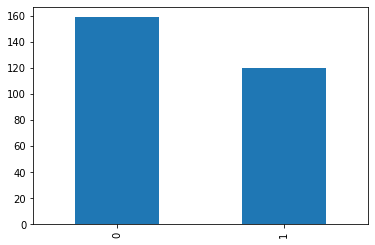

In [114]:
df['category'].value_counts().plot.bar()

4. Criando o modelo da rede neural:

In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization


In [116]:
model=Sequential()

In [117]:
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [118]:
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [119]:
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [120]:
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

In [121]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

5. Analisando o modelo:

In [122]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 61, 61, 64)      

6. Definindo as chamadas de retorno e taxa de aprendizado:

In [123]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]


7. Gerenciando os dados:

In [124]:
df["category"] = df["category"].replace({0:'Normal', 1:'True'})
train_df,validate_df = train_test_split(df, test_size=0.20, random_state=42)

In [125]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [126]:
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=10

8. Gerando dados de treinamento e validação:

In [127]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1
                                  )


In [128]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    "Dataset/Treino",
                                                    x_col='filename',
                                                    y_col='category',
                                                    target_size=Image_Size,
                                                    class_mode='categorical',
                                                    batch_size=batch_size)


Found 223 validated image filenames belonging to 2 classes.


In [129]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "Dataset/Treino", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)
test_datagen = ImageDataGenerator(rotation_range=15,
                                  rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)


Found 56 validated image filenames belonging to 2 classes.


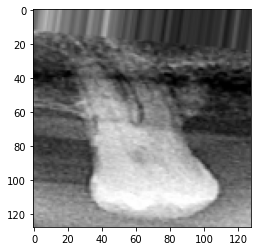

In [130]:
x , y  = train_generator.next()
for i in range(0,1):
    random_image = x[i]
    plt.imshow(random_image)
    plt.show()

9. Treinamento do modelo:

In [131]:
epochs=10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


Epoch 1/10
22/22 [==============================] - 13s 546ms/step - loss: 1.2302 - accuracy: 0.7183 - val_loss: 0.7644 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 2/10
22/22 [==============================] - 14s 654ms/step - loss: 1.0351 - accuracy: 0.6995 - val_loss: 0.5888 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 3/10
22/22 [==============================] - 12s 557ms/step - loss: 0.8811 - accuracy: 0.6901 - val_loss: 3.3725 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 4/10
22/22 [==============================] - 16s 721ms/step - loss: 0.7774 - accuracy: 0.7653 - val_loss: 6.6155 - val_accuracy: 0.4600 - lr: 0.0010
Epoch 5/10
22/22 [==============================] - 20s 905ms/step - loss: 0.6319 - accuracy: 0.7465 - val_loss: 8.0530 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 6/10
22/22 [==============================] - 26s 1s/step - loss: 0.6922 - accuracy: 0.7089 - val_loss: 8.3320 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 7/10
22/22 [==============================] - 38s 2s/step - l

10. Salvando o modelo:

In [132]:
model.save("model1_dental_care.h5")

11. Preparando os dados de teste:

In [133]:
test_filenames = os.listdir("Dataset/Teste")

test_df = pd.DataFrame({
    'filename': test_filenames
})

12. Testando os dados de treinamento:

In [134]:
test_generator = train_datagen.flow_from_dataframe(test_df,
                                                   "Dataset/Teste",
                                                   x_col='filename',
                                                   y_col=None,
                                                   target_size=Image_Size,
                                                   class_mode=None,
                                                   batch_size=batch_size
                                                   )

nb_samples = test_df.shape[0]


Found 54 validated image filenames.


13. Fazendo as previsões das categorias:

In [135]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

6/6 [==============================] - 1s 132ms/step


14. Convertendo os labels em categorias:

In [136]:
test_df['category'] = np.argmax(predict, axis=-1)

In [137]:

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)


In [138]:
test_df['category'] = test_df['category'].replace({ 'cárie': 1, 'normal': 0 })

15. Visualizando os resultados da previsão:

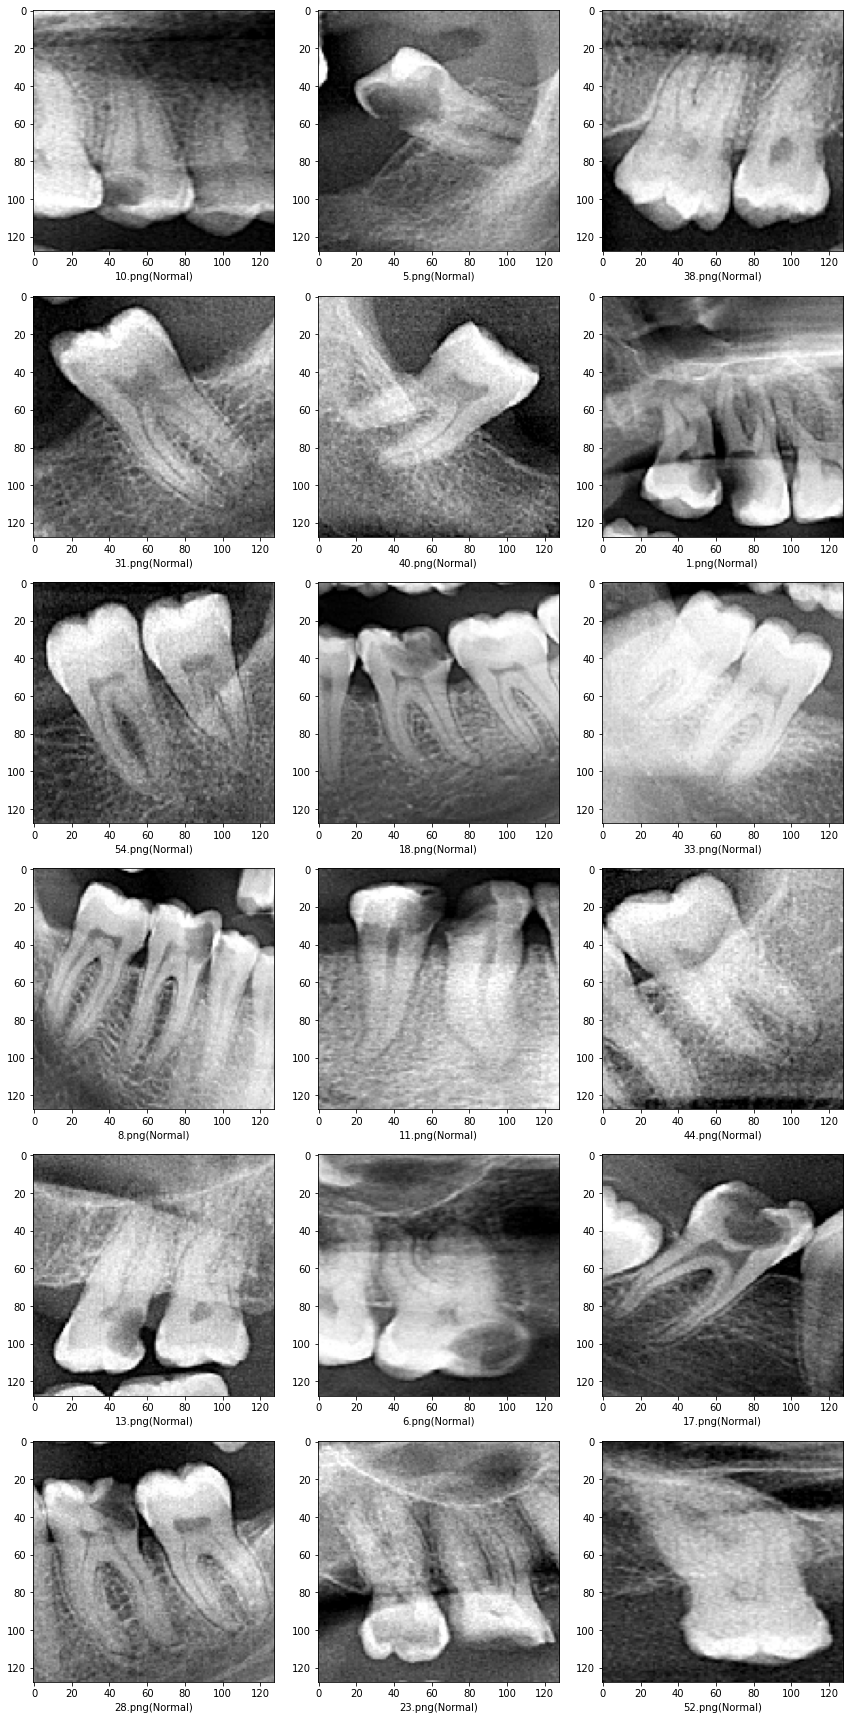

In [139]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("Dataset/Teste/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()


16. Testando o desempenho do modelo em dados personalizados:

In [140]:
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2

In [141]:
im=Image.open("Dataset/Treino/caries.38.png")
img=im
im=im.resize(Image_Size)
im=(np.random.standard_normal([128,128,3])*255)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict([im])[0]


1/1 [==============================] - 0s 243ms/step


In [142]:
print(pred)

[0.5474441  0.45255587]


In [143]:
if pred[0] > pred[1]:
    print ('Diagnóstico indicado: este dente possui cárie')
else:
    print('Diagnóstico indicado: este dente não possui cárie')


Diagnóstico indicado: dente cárie


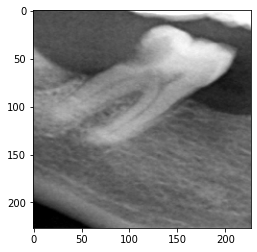

In [144]:
plt.imshow(img)
plt.show()

# Classificador GUI para imagens odontológicas

2. Gerando a GUI: